In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sklean imports 
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.metrics import *

In [2]:
# Set colour palette 

greys = ['#767676', '#b3b3b3', '#212121']
sns.set_palette(sns.color_palette(greys))


# Data import and cleaning 

In [3]:
# Data import
df_raw = pd.read_csv('48_Industry_Portfolios_Daily.csv', skiprows=range(0,9))
df_raw.drop(axis=0, labels=range(25292,len(df_raw)), inplace=True)

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\4267491402.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('48_Industry_Portfolios_Daily.csv', skiprows=range(0,9))


In [4]:
# Data cleaning 
df = df_raw.copy()
df = df.apply(pd.to_numeric)
df.rename(columns={'Unnamed: 0':'Date'}, inplace=True)

tmp = df.columns
tmp = list(tmp)

#--------------------------------------------------------------------------------------------------
# Column headers have random spaces, so i removed them 
out = []
for i in tmp:
    out.append(i.replace(' ', ''))

df.columns = out

# Changing date to actual date format 
df['Date'] = df['Date'].astype(str)
df['Date'] = df['Date'].apply(lambda x: (x[:4] + '-' + x[4:6] + '-' + x[6:]))
df['Date'] = pd.to_datetime(df['Date'])

df.head()
#df.info()

,Date,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,1926-07-01,0.56,-0.07,-99.99,-1.39,0.00,-1.44,0.62,-1.27,-0.90,...,-0.93,0.14,2.77,-0.02,0.27,0.59,0.47,0.81,0.57,-1.66
1,1926-07-02,0.29,0.06,-99.99,0.78,0.70,1.46,0.03,0.00,-0.34,...,1.07,0.07,0.00,0.01,-0.10,1.04,-0.03,-0.61,-1.03,3.09
2,1926-07-06,-0.33,0.18,-99.99,-1.74,0.50,-0.96,-0.06,4.27,-1.20,...,0.73,-0.20,0.77,-0.22,-0.67,0.45,0.31,-0.72,0.62,1.41
3,1926-07-07,3.57,-0.15,-99.99,-1.73,-0.12,-0.49,-0.06,-4.10,-0.22,...,2.22,0.18,-3.21,-0.57,-1.08,-1.09,0.21,0.07,0.17,0.62
4,1926-07-08,0.30,1.12,-99.99,-0.15,0.30,-0.49,0.24,0.00,-0.01,...,-0.39,0.46,-1.10,-0.38,0.33,0.99,-0.88,-0.36,-1.10,0.98


# Trying to get the correct min var portfolio 

In [5]:
# Selecting only the most recent 63 days 
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

temp = df.copy()
temp = temp.iloc[date_i-no_obj:date_i,:]
temp.shape

(63, 49)

In [6]:
# FOR TESTING 
temp = temp[['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys']]
temp.head()

,Agric,Food,Soda,Beer,Smoke,Toys
25085,-2.01,0.10,-0.39,-0.35,0.57,-3.49
25086,1.91,0.75,0.51,0.36,-0.13,1.07
25087,-2.85,1.00,1.03,1.84,0.38,1.78
25088,1.04,-0.07,0.36,1.08,-0.63,2.05
25089,0.48,-0.48,0.09,-0.01,0.00,-1.04


In [7]:
# Use the first 63 as training data
R_train = temp
sc = StandardScaler(with_std = False)
R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])

In [8]:
arr_len = 6

# Getting y
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)

y_train = np.dot(R_train, eq_w)

'''
print('Equal weight portfolio: {}'.format(eq_w))
print('\n')
print('y_train: {}'.format(y_train))
'''

"\nprint('Equal weight portfolio: {}'.format(eq_w))\nprint('\n')\nprint('y_train: {}'.format(y_train))\n"

In [9]:
# N matrix 
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

print(R_train.shape, N.shape)

# Calculate X
X_train = np.dot(R_train, N)

'''
print('N matrix: {}'.format(N))
print('\n')
print('X_train: {}'.format(X_train))
'''

(63, 6) (6, 5)


"\nprint('N matrix: {}'.format(N))\nprint('\n')\nprint('X_train: {}'.format(X_train))\n"

In [10]:
# Linear regression to get min var portfolio
reg = LinearRegression(fit_intercept = False)
reg.fit(X_train, y_train)

train_r2 = reg.score(X_train, y_train)
train_mse = mean_squared_error(y_train, reg.predict(X_train))

beta = reg.coef_
w = eq_w - np.dot(N,beta)

#--------------------------------------------------------------------------------------------------

'''
test_r2 = reg.score(X_test, y_test)
test_mse = mean_squared_error(y_test, ridge.predict(X_test))
'''

print(f'train_r2: {train_r2}')
print(f'train_mse: {train_mse}')
print('\n')

print(f'beta: {beta}')
print(f'w            : {[round(num, 3) for num in w]}')
print(f'Actual values: {str([-.002, -.004, .049, .514, .316, .128])}')

'''
print(test_r2)
print(test_mse)
'''

train_r2: 0.22247593212981887
train_mse: 0.46020583341227367


beta: [ 0.16927953  0.16834143  0.11724264 -0.34557298 -0.14832212]
w            : [-0.003, -0.002, 0.049, 0.512, 0.315, 0.128]
Actual values: [-0.002, -0.004, 0.049, 0.514, 0.316, 0.128]


'\nprint(test_r2)\nprint(test_mse)\n'

# Q1. 

### Model fit scatter plot (to explain overfitting) [CAN USE]

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\3597626739.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\seanl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an e

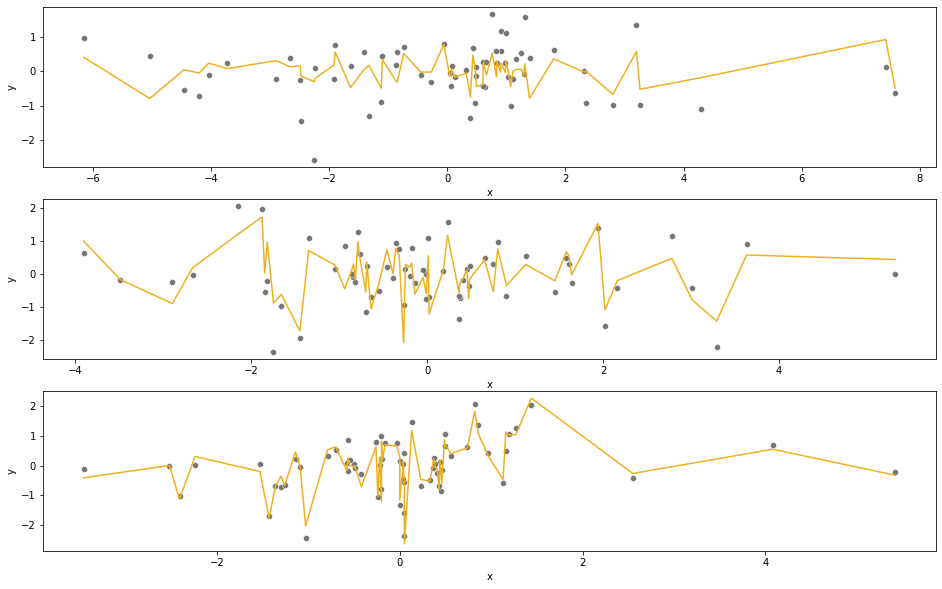

In [11]:
covariates = [6, 24, 48]
fig, axs = plt.subplots(nrows=3, figsize=(16,10))
counter = 0


for cov_num in covariates:
    # This is all code to get the data into dataframe
    # Selecting the columns 
    temp = df.copy()
    temp = temp.iloc[:,1: cov_num+1]
    
    # Selecting training set
    date = '2022-01-03'
    no_obj = 63
    date_i = df[df['Date'] == date].index[0]

    R_train = temp.iloc[date_i-63:date_i,:]

    sc = StandardScaler(with_std = False)
    R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])

    #-------------------------------------------------------------------------------------------
    # Processing
    arr_len = cov_num
    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )
    y_temp = np.dot(R_train, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)
    
    # Calculate X
    X_temp = np.dot(R_train, N)

    #-------------------------------------------------------------------------------------------
    temp_df = pd.DataFrame(X_temp)
    temp_df.columns = ['X' + str(i) for i in temp_df.columns]
    temp_df.insert(1, 'y', y_temp)
    temp_df = temp_df.rename({'X0':'x'}, axis=1)
    
    ols = LinearRegression()
    features = temp_df.drop('y', axis = 1)
    target = temp_df['y']
    ols.fit(features, target)
    preds = ols.predict(features)
    sns.scatterplot(temp_df.x, temp_df.y, color='#767676', ax=axs[counter])
    sns.lineplot(temp_df.x, preds, color='#edb021', ax=axs[counter])
    
    
    counter += 1

    
    
plt.show()


### Relationship between -log(alpha) and MSE

In [12]:
# Selecting the columns 
q1 = df.copy()
q1 = q1[['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']]
q1.head()

,Trans,Hshld,Guns,LabEq,Fin,Hlth
0,0.14,-0.90,-99.99,0.00,0.57,-99.99
1,0.07,-0.34,-99.99,1.80,-1.03,-99.99
2,-0.20,-1.20,-99.99,0.66,0.62,-99.99
3,0.18,-0.22,-99.99,-0.66,0.17,-99.99
4,0.46,-0.01,-99.99,0.33,-1.10,-99.99


In [13]:
# Selecting training set
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

R_train = q1.iloc[date_i-no_obj:date_i,:]

sc = StandardScaler(with_std = False)
R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])

R_train.shape

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2673868038.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])


(63, 6)

In [14]:
# Selecting the test set (dates after the 1 day in 2022)
date = '2022-01-03'
no_obj = int(63 / .7 * .3)
date_i = df[df['Date'] == date].index[0]

R_test = q1.iloc[date_i:date_i+no_obj,:]

sc = StandardScaler(with_std = False)
R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])

R_test.shape

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\38191106.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])


(27, 6)

### Ridge

In [15]:
arr_len = 6

# y values
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)

y_train = np.dot(R_train, eq_w)
y_test = np.dot(R_test, eq_w)

#--------------------------------------------------------------------------------------------------

# X values
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

X_train = np.dot(R_train, N)
X_test = np.dot(R_test, N)

'''
print('y_train: {}'.format(y_train))
print('y_test: {}'.format(y_test))
print('\n')
print('X_train: {}'.format(X_train))
print('X_test: {}'.format(X_test))
'''

"\nprint('y_train: {}'.format(y_train))\nprint('y_test: {}'.format(y_test))\nprint('\n')\nprint('X_train: {}'.format(X_train))\nprint('X_test: {}'.format(X_test))\n"

In [16]:
alpha_vec = np.logspace(-10,3,100)

# results list 
train_r2 = []
train_mse = []
coeff_dict = {}

test_r2 = []
test_mse = []

for cur_alpha in alpha_vec:
    ridge = Ridge(cur_alpha)
    ridge.fit(X_train, y_train)
    
    # Training
    train_r2.append(ridge.score(X_train, y_train))
    train_mse.append(mean_squared_error(y_train, ridge.predict(X_train)))
    coeff_dict[cur_alpha] = ridge.coef_
    
    # Test 
    test_r2.append(ridge.score(X_test, y_test))
    test_mse.append(mean_squared_error(y_test, ridge.predict(X_test)))
    


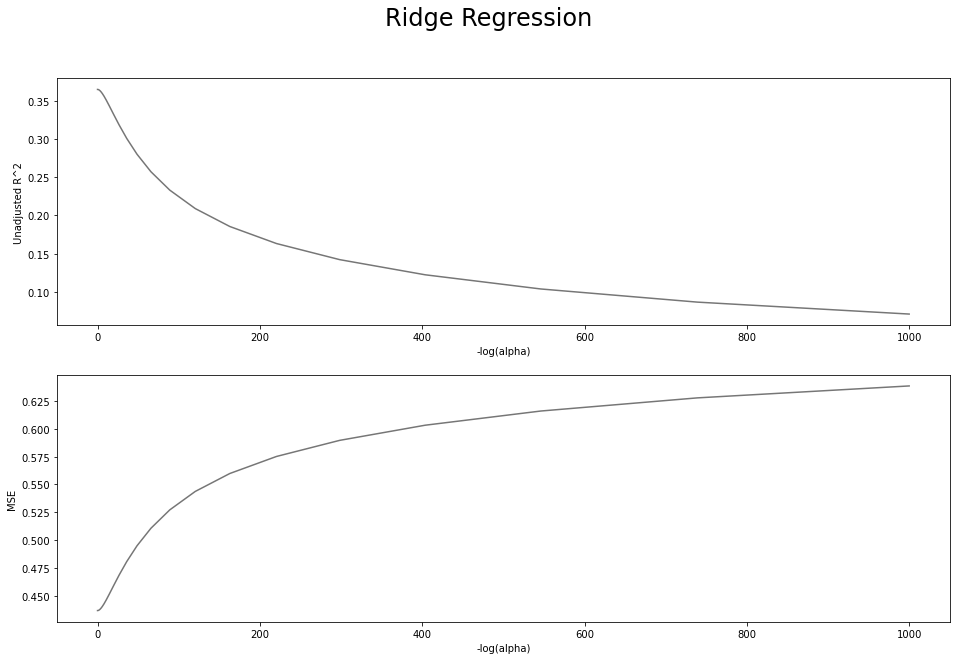

In [17]:
# r2 and mse plots for training 
fig, axs = plt.subplots(nrows=2, figsize=(16,10))
sns.lineplot(x=alpha_vec, y=np.array(train_r2), ax=axs[0])
axs[0].set(xlabel='-log(alpha)', ylabel='Unadjusted R^2')

sns.lineplot(x=alpha_vec, y=np.array(train_mse), ax=axs[1])
axs[1].set(xlabel='-log(alpha)', ylabel='MSE')

fig.suptitle('Ridge Regression', fontsize = 24)

plt.show()

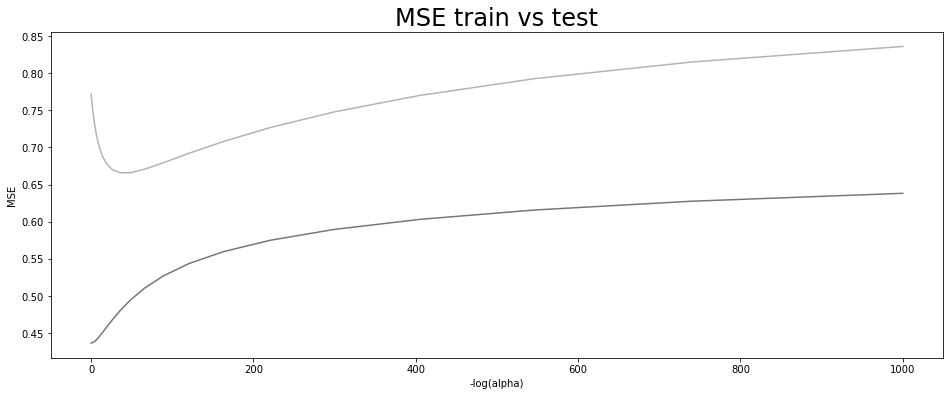

In [18]:
# mse plots for training vs test 
plt.figure(figsize=(16,6))
fig1 = sns.lineplot(x=alpha_vec, y=np.array(train_mse))
fig1 = sns.lineplot(x=alpha_vec, y=np.array(test_mse))
fig1.set(xlabel='-log(alpha)', ylabel='MSE')
plt.title('MSE train vs test', fontsize = 24)

plt.show()

### Lasso

In [19]:
alpha_vec = np.logspace(-10,0,100)

# results list 
train_r2 = []
train_mse = []
coeff_dict = {}

test_r2 = []
test_mse = []


# iterate over all alphas in range
for cur_alpha in alpha_vec:
    lasso = Lasso(cur_alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    
    # Training
    train_r2.append(lasso.score(X_train, y_train))
    train_mse.append(mean_squared_error(y_train, lasso.predict(X_train)))
    coeff_dict[cur_alpha] = ridge.coef_
    
    # Test 
    test_r2.append(lasso.score(X_test, y_test))
    test_mse.append(mean_squared_error(y_test, lasso.predict(X_test)))

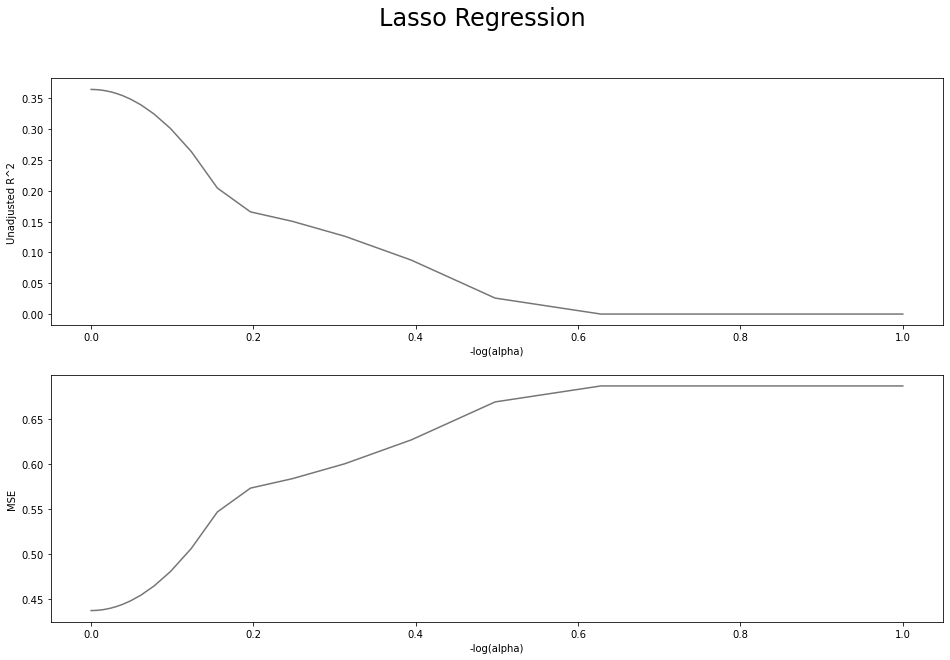

In [20]:
# r2 and mse plots for training 
fig, axs = plt.subplots(nrows=2, figsize=(16,10))
sns.lineplot(x=alpha_vec, y=np.array(train_r2), ax=axs[0])
axs[0].set(xlabel='-log(alpha)', ylabel='Unadjusted R^2')

sns.lineplot(x=alpha_vec, y=np.array(train_mse), ax=axs[1])
axs[1].set(xlabel='-log(alpha)', ylabel='MSE')

fig.suptitle('Lasso Regression', fontsize = 24)

plt.show()

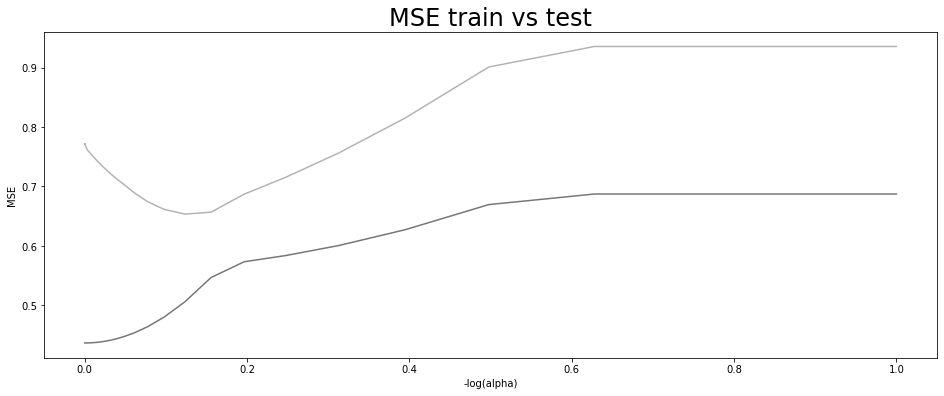

In [21]:
# mse plots for training vs test 
plt.figure(figsize=(16,6))
fig1 = sns.lineplot(x=alpha_vec, y=np.array(train_mse))
fig1 = sns.lineplot(x=alpha_vec, y=np.array(test_mse))
fig1.set(xlabel='-log(alpha)', ylabel='MSE')
plt.title('MSE train vs test', fontsize = 24)

plt.show()

### GridsearchCV 

In [22]:
def test(models, data, iterations = 100):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(data[X], 
                                                                data[Y], 
                                                                test_size= 0.2)
            r2_test.append(metrics.r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(metrics.r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)

In [23]:
models = {'OLS': LinearRegression(),
         'Lasso': Lasso(),
         'Ridge': Ridge(),}

X = ['x']
X.extend(temp_df.columns[2:])
Y = ['y']


test(models, temp_df)

# This shows the models performance! 

,OLS,Lasso,Ridge
0,0.989035,0.000000,0.956957
1,-24.266415,-0.093686,-0.640904


### Finding the best value of alpha done below!! 

In [46]:
# Cross validation inputs 

temp = df.copy()
temp = temp.iloc[:,1: cov_num+1]

# Selecting training set
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

R_train = temp.iloc[date_i-no_obj:date_i,:]

# Selecting the test set (dates after the 1 day in 2022)
date = '2022-01-03'
no_obj = int(63 / .7 * .3)
date_i = df[df['Date'] == date].index[0]

R_test = temp.iloc[date_i:date_i+no_obj,:]

# Getting y
arr_len = R_train.shape[1]

eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)
y_train_raw = np.dot(R_train, eq_w)
y_test_raw = np.dot(R_train, eq_w)

# N matrix 
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

# Calculate X
X_train_raw = np.dot(R_train, N)
X_test_raw = np.dot(R_train, N)

In [47]:

pipe_r = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                         ("ridge", Ridge())])

ridge_params = {'ridge__alpha':np.logspace(-8,3,100)}

grid_r = GridSearchCV(estimator=pipe_r, param_grid=ridge_params, n_jobs=-1,  cv = 8)

grid_r.fit(X_train_raw, y_train_raw)

#--------------------------------------------------------------------------------------------------

pipe_l = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                         ("lasso", Lasso())])

lasso_params = {'lasso__alpha':np.logspace(-8,0,100)}

grid_l = GridSearchCV(estimator=pipe_l, param_grid=lasso_params, n_jobs=-1,  cv = 8)

grid_l.fit(X_train_raw, y_train_raw)

#--------------------------------------------------------------------------------------------------


print(f'Ridge best alpha: {grid_r.best_params_}')
print(f'Ridge best score: {grid_r.best_score_}')

print('\n')

print(f'Lasso best alpha: {grid_l.best_params_}')
print(f'Lasso best score: {grid_l.best_score_}')

Ridge best alpha: {'ridge__alpha': 100.0}
Ridge best score: 0.2142625465078659


Lasso best alpha: {'lasso__alpha': 0.12915496650148853}
Lasso best score: 0.17357426844873278


# Cross Validation 

### Ridge 

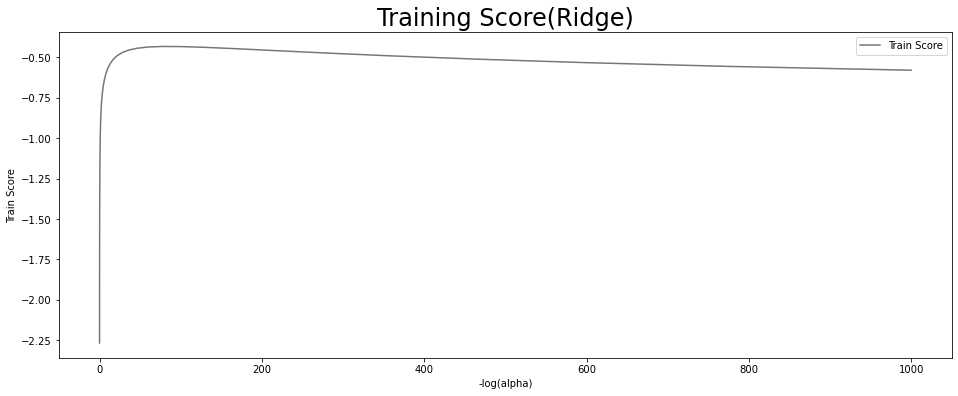

Ridge alpha: 100.0


Test set MSE: 0.24673300187415947
Test set Rsq: 0.680262606916253


In [51]:
alpha_vec = np.logspace(-8,3,100)


cvResults = []

# iterate over all alphas in range
for cur_alpha in alpha_vec:

    clf_cv = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                             ("ridge", Ridge(cur_alpha))])
    
    # Perform 10-fold cross validation 
    scores = cross_val_score(estimator = clf_cv, X = X_train_raw, y = y_train_raw, cv = 8, \
                             scoring = 'neg_mean_squared_error', n_jobs = -1)
    
    cvResults.append(scores.mean())

#--------------------------------------------------------------------------------------------------

# Graph
plt.figure(figsize=(16,6))
fig2 = sns.lineplot(y = cvResults, x = alpha_vec, label = "Train Score")
plt.title('Training Score(Ridge)', fontsize = 24)
fig2.set(xlabel='-log(alpha)', ylabel='Train Score')
plt.show()

#--------------------------------------------------------------------------------------------------

# Stats (could be wrong!)
ridgecv = RidgeCV(alphas = alpha_vec, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_train_raw, y_train_raw)
ridge_best_alpha = ridgecv.alpha_
print('Ridge alpha: {}'.format(ridgecv.alpha_))
print('\n')


# refit on full dataset with optimized parameter
opt_ridge = Ridge(alpha = ridgecv.alpha_)
opt_ridge.fit(X_train_raw, y_train_raw)

# Test set (could be wrong!)
print('Test set MSE: {}'.format(mean_squared_error(y_test_raw, opt_ridge.predict(X_test_raw))))
print('Test set Rsq: {}'.format(r2_score(y_test_raw, opt_ridge.predict(X_test_raw))))

### Lasso

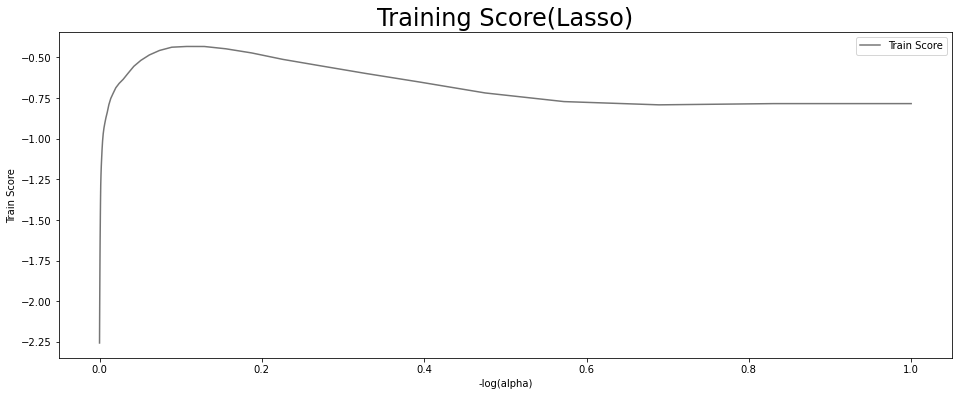

Lasso alpha: 0.10722672220103253


Test set MSE: 0.2667012716232712
Test set Rsq: 0.6543860421053957


In [52]:
alpha_vec = np.logspace(-8,0,100)

cvResults = []

for cur_alpha in alpha_vec:
    clf_cv = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                             ("ridge", Lasso(cur_alpha))])
    
    # Perform 10-fold cross validation 
    scores = cross_val_score(estimator = clf_cv, X = X_train_raw, y = y_train_raw, cv = 8, \
                             scoring = 'neg_mean_squared_error', n_jobs = -1)
    
    # Attach results
    cvResults.append(scores.mean())

#--------------------------------------------------------------------------------------------------

# Graph
plt.figure(figsize=(16,6))
fig2 = sns.lineplot(y = cvResults, x = alpha_vec, label = "Train Score")
plt.title('Training Score(Lasso)', fontsize = 24)
fig2.set(xlabel='-log(alpha)', ylabel='Train Score')
plt.show()

#--------------------------------------------------------------------------------------------------

# Stats (Could be wrong!)
lassocv = LassoCV(alphas = alpha_vec, max_iter=10000)
lassocv.fit(X_train_raw, y_train_raw)
lasso_best_alpha = lassocv.alpha_
print(f'Lasso alpha: {lassocv.alpha_}')
print('\n')

# refit on full dataset with optimized parameter
opt_lasso = Lasso(alpha = lassocv.alpha_)
opt_lasso.fit(X_train_raw, y_train_raw)

# assess on test set (could be wrong!)
print(f'Test set MSE: {mean_squared_error(y_test_raw, opt_lasso.predict(X_test_raw))}')
print(f'Test set Rsq: {r2_score(y_test_raw, opt_lasso.predict(X_test_raw))}')

# Q2. Repeat the above procedure for 24 as well as 48 industries

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\1234168697.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\1234168697.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\1234168697.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

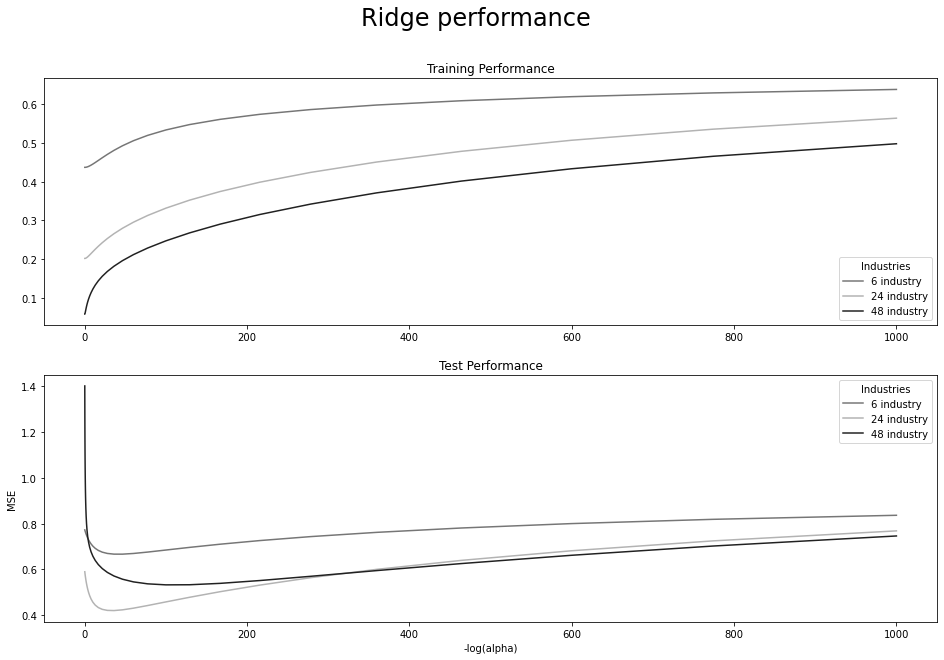

In [27]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]

testing = [ind_6, ind_24, ind_48]
q2_fig, axs = plt.subplots(nrows=2, figsize=(16,10))

#--------------------------------------------------------------------------------------------------

for test in testing:
    q2_temp = df.copy()
    q2_temp = q2_temp[test]
    
    # Selecting training set
    date = '2022-01-03'
    no_obj = 63
    date_i = df[df['Date'] == date].index[0]

    R_train = q2_temp.iloc[date_i-no_obj:date_i,:]

    sc = StandardScaler(with_std = False)
    R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])


    # Selecting the test set (dates after the 1 day in 2022)
    date = '2022-01-03'
    no_obj = int(63 / .7 * .3)
    date_i = df[df['Date'] == date].index[0]

    R_test = q2_temp.iloc[date_i:date_i+no_obj,:]

    sc = StandardScaler(with_std = False)
    R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])

    '''    
    print(f'Training set shape: {R_train.shape}')
    print(f'Test set shape: {R_test.shape}')
    '''

    arr_len = len(test)

    # y values
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )

    y_train = np.dot(R_train, eq_w)
    y_test = np.dot(R_test, eq_w)


    # X values
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    X_train = np.dot(R_train, N)
    X_test = np.dot(R_test, N)

    # Model fitting
    alpha_vec = np.logspace(-8,3,100)

    train_r2_all = []
    train_mse_all = []
    coeff_dict_all = {}

    test_r2_all = []
    test_mse_all = []

    for cur_alpha in alpha_vec:
        ridge = Ridge(cur_alpha)
        ridge.fit(X_train, y_train)

        # Training
        train_r2_all.append(ridge.score(X_train, y_train))
        train_mse_all.append(mean_squared_error(y_train, ridge.predict(X_train)))
        coeff_dict_all[cur_alpha] = ridge.coef_

        # Test 
        test_r2_all.append(ridge.score(X_test, y_test))
        test_mse_all.append(mean_squared_error(y_test, ridge.predict(X_test)))
        
    
    q2_fig = sns.lineplot(x=alpha_vec, y=np.array(train_mse_all), ax=axs[0])
    q2_fig = sns.lineplot(x=alpha_vec, y=np.array(test_mse_all), ax=axs[1])

#--------------------------------------------------------------------------------------------------

axs[0].legend(title='Industries', labels=['6 industry', '24 industry', '48 industry'])
axs[0].title.set_text('Training Performance')
axs[1].legend(title='Industries', labels=['6 industry', '24 industry', '48 industry'])
axs[1].title.set_text('Test Performance')
q2_fig.set(xlabel='-log(alpha)', ylabel='MSE')

plt.suptitle('Ridge performance', fontsize = 24)
plt.show()

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\1694064957.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\1694064957.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\1694064957.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.697e-02, tolerance: 4.862e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.677e-02, tolerance: 4.862e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.924e-02, toleranc

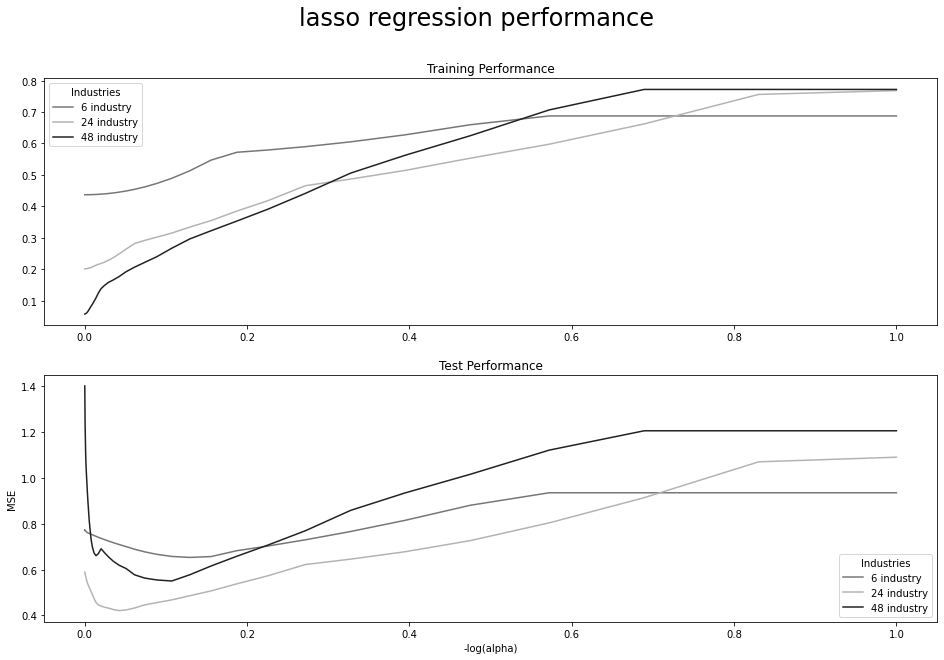

In [28]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]

testing = [ind_6, ind_24, ind_48]
q2_fig, axs = plt.subplots(nrows=2, figsize=(16,10))

#--------------------------------------------------------------------------------------------------

for test in testing:
    q2_temp = df.copy()
    q2_temp = q2_temp[test]
    
    # Selecting training set
    date = '2022-01-03'
    no_obj = 63
    date_i = df[df['Date'] == date].index[0]

    R_train = q2_temp.iloc[date_i-no_obj:date_i,:]

    sc = StandardScaler(with_std = False)
    R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])


    # Selecting the test set (dates after the 1 day in 2022)
    date = '2022-01-03'
    no_obj = int(63 / .7 * .3)
    date_i = df[df['Date'] == date].index[0]

    R_test = q2_temp.iloc[date_i:date_i+no_obj,:]

    sc = StandardScaler(with_std = False)
    R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])

    '''    
    print(f'Training set shape: {R_train.shape}')
    print(f'Test set shape: {R_test.shape}')
    '''

    arr_len = len(test)

    # y values
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )

    y_train = np.dot(R_train, eq_w)
    y_test = np.dot(R_test, eq_w)


    # X values
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    X_train = np.dot(R_train, N)
    X_test = np.dot(R_test, N)

    # Model fitting
    alpha_vec = np.logspace(-8,0,100)

    train_r2_all = []
    train_mse_all = []
    coeff_dict_all = {}

    test_r2_all = []
    test_mse_all = []

    for cur_alpha in alpha_vec:
        lasso = Lasso(cur_alpha)
        lasso.fit(X_train, y_train)

        # Training
        train_r2_all.append(lasso.score(X_train, y_train))
        train_mse_all.append(mean_squared_error(y_train, lasso.predict(X_train)))
        coeff_dict_all[cur_alpha] = lasso.coef_

        # Test 
        test_r2_all.append(lasso.score(X_test, y_test))
        test_mse_all.append(mean_squared_error(y_test, lasso.predict(X_test)))
        
    
    q2_fig = sns.lineplot(x=alpha_vec, y=np.array(train_mse_all), ax=axs[0])
    q2_fig = sns.lineplot(x=alpha_vec, y=np.array(test_mse_all), ax=axs[1])

#--------------------------------------------------------------------------------------------------

axs[0].legend(title='Industries', labels=['6 industry', '24 industry', '48 industry'])
axs[0].title.set_text('Training Performance')
axs[1].legend(title='Industries', labels=['6 industry', '24 industry', '48 industry'])
axs[1].title.set_text('Test Performance')
q2_fig.set(xlabel='-log(alpha)', ylabel='MSE')

plt.suptitle('lasso regression performance', fontsize = 24)
plt.show()

# Q3. (For these answers, it could be possible to use the optimum alpha ?)

### 42 vs 63 vs 84 Observations

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\1578271772.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\1578271772.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\1578271772.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

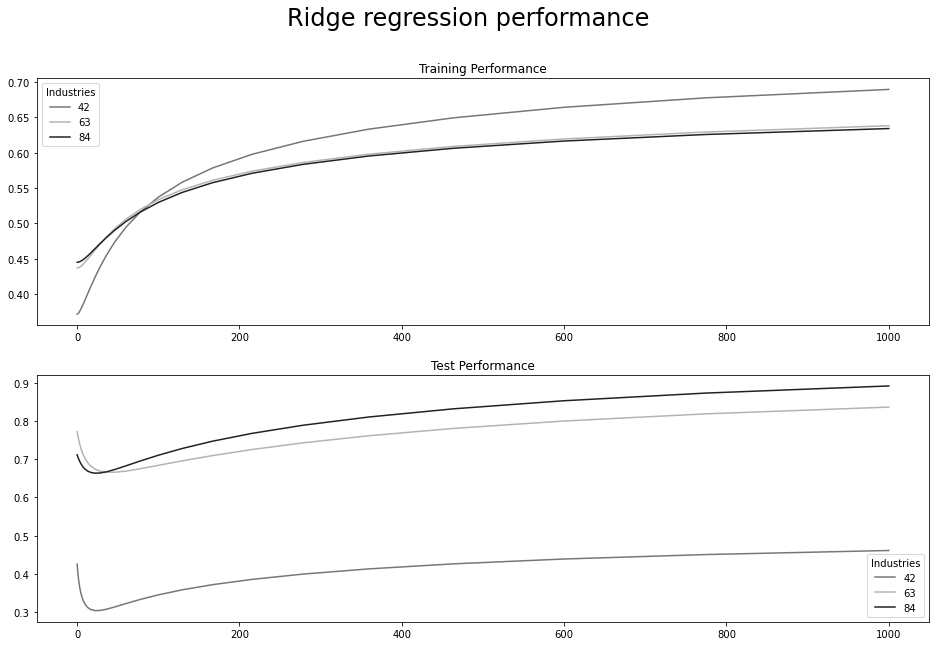

In [29]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]

observations = [42, 63, 84]

q3_fig, axs = plt.subplots(nrows=2, figsize=(16,10))

#--------------------------------------------------------------------------------------------------

for obv in observations:
    q3_temp = df.copy()
    q3_temp = q3_temp[ind_6]
    
    # Selecting training set
    date = '2022-01-03'
    no_obj = obv
    date_i = df[df['Date'] == date].index[0]

    R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

    sc = StandardScaler(with_std = False)
    R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])


    # Selecting the test set (dates after the 1 day in 2022)
    date = '2022-01-03'
    no_obj = int(obv / .7 * .3)
    date_i = df[df['Date'] == date].index[0]

    R_test = q3_temp.iloc[date_i:date_i+no_obj,:]

    sc = StandardScaler(with_std = False)
    R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])

    '''    
    print(f'Training set shape: {R_train.shape}')
    print(f'Test set shape: {R_test.shape}')
    '''

    arr_len = len(ind_6)

    # y values
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )

    y_train = np.dot(R_train, eq_w)
    y_test = np.dot(R_test, eq_w)


    # X values
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    X_train = np.dot(R_train, N)
    X_test = np.dot(R_test, N)

    # Model fitting
    alpha_vec = np.logspace(-8,3,100)

    train_r2_all = []
    train_mse_all = []
    coeff_dict_all = {}

    test_r2_all = []
    test_mse_all = []

    for cur_alpha in alpha_vec:
        ridge = Ridge(cur_alpha)
        ridge.fit(X_train, y_train)

        # Training
        train_r2_all.append(ridge.score(X_train, y_train))
        train_mse_all.append(mean_squared_error(y_train, ridge.predict(X_train)))
        coeff_dict_all[cur_alpha] = ridge.coef_

        # Test 
        test_r2_all.append(ridge.score(X_test, y_test))
        test_mse_all.append(mean_squared_error(y_test, ridge.predict(X_test)))
        
    q3_fig = sns.lineplot(x=alpha_vec, y=np.array(train_mse_all), ax=axs[0])
    q3_fig = sns.lineplot(x=alpha_vec, y=np.array(test_mse_all), ax=axs[1])

#--------------------------------------------------------------------------------------------------

axs[0].legend(title='Industries', labels=['42', '63', '84'])
axs[0].title.set_text('Training Performance')
axs[1].legend(title='Industries', labels=['42', '63', '84'])
axs[1].title.set_text('Test Performance')
q2_fig.set(xlabel='-log(alpha)', ylabel='MSE')

plt.suptitle('Ridge regression performance', fontsize = 24)
plt.show()

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\84151372.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\84151372.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\84151372.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

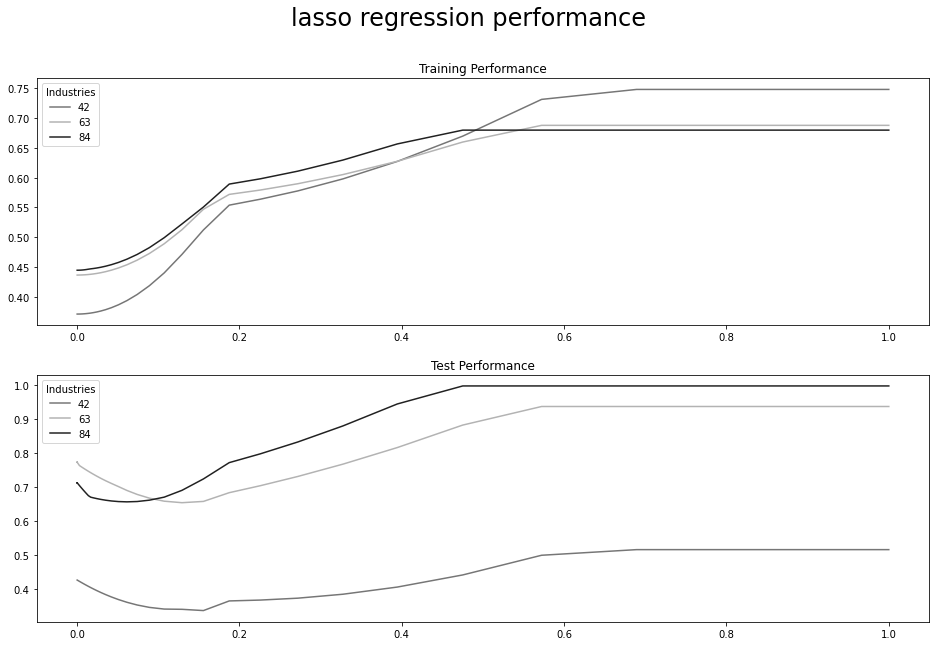

In [30]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]

observations = [42, 63, 84]

q3_fig, axs = plt.subplots(nrows=2, figsize=(16,10))

#--------------------------------------------------------------------------------------------------

for obv in observations:
    q3_temp = df.copy()
    q3_temp = q3_temp[ind_6]
    
    # Selecting training set
    date = '2022-01-03'
    no_obj = obv
    date_i = df[df['Date'] == date].index[0]

    R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

    sc = StandardScaler(with_std = False)
    R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])


    # Selecting the test set (dates after the 1 day in 2022)
    date = '2022-01-03'
    no_obj = int(obv / .7 * .3)
    date_i = df[df['Date'] == date].index[0]

    R_test = q3_temp.iloc[date_i:date_i+no_obj,:]

    sc = StandardScaler(with_std = False)
    R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])

    '''    
    print(f'Training set shape: {R_train.shape}')
    print(f'Test set shape: {R_test.shape}')
    '''

    arr_len = len(ind_6)

    # y values
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )

    y_train = np.dot(R_train, eq_w)
    y_test = np.dot(R_test, eq_w)


    # X values
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)

    X_train = np.dot(R_train, N)
    X_test = np.dot(R_test, N)

    # Model fitting
    alpha_vec = np.logspace(-8,0,100)

    train_r2_all = []
    train_mse_all = []
    coeff_dict_all = {}

    test_r2_all = []
    test_mse_all = []

    for cur_alpha in alpha_vec:
        lasso = Lasso(cur_alpha)
        lasso.fit(X_train, y_train)

        # Training
        train_r2_all.append(lasso.score(X_train, y_train))
        train_mse_all.append(mean_squared_error(y_train, lasso.predict(X_train)))
        coeff_dict_all[cur_alpha] = lasso.coef_

        # Test 
        test_r2_all.append(lasso.score(X_test, y_test))
        test_mse_all.append(mean_squared_error(y_test, lasso.predict(X_test)))
        
    q3_fig = sns.lineplot(x=alpha_vec, y=np.array(train_mse_all), ax=axs[0])
    q3_fig = sns.lineplot(x=alpha_vec, y=np.array(test_mse_all), ax=axs[1])

#--------------------------------------------------------------------------------------------------

axs[0].legend(title='Industries', labels=['42', '63', '84'])
axs[0].title.set_text('Training Performance')
axs[1].legend(title='Industries', labels=['42', '63', '84'])
axs[1].title.set_text('Test Performance')
q2_fig.set(xlabel='-log(alpha)', ylabel='MSE')

plt.suptitle('lasso regression performance', fontsize = 24)
plt.show()

### Showing performance of model with deffering observations

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

45
45


C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])
C:\Users\seanl\AppData\Local\Temp\ipykernel_6056\2043044351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

45
45


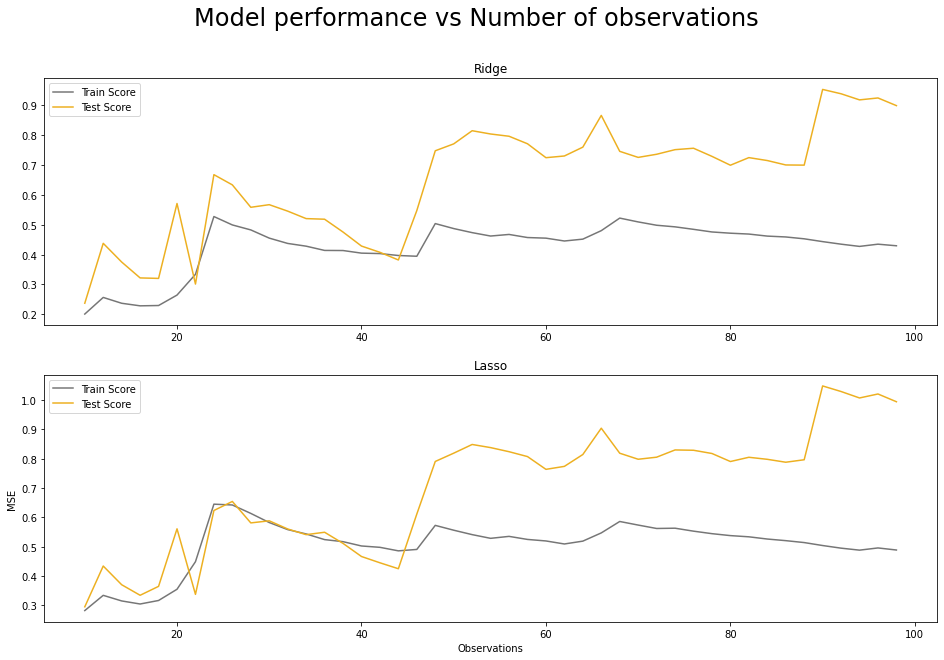

In [38]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]

regressions = [Ridge, Lasso]

observations = list(np.arange(10,100,2))

fig, axs = plt.subplots(nrows=2, figsize=(16,10))

#--------------------------------------------------------------------------------------------------
counter = 0

for reg in regressions:
    plotting_train_mse = []
    plotting_test_mse = []
    for obv in observations:
        q3_temp = df.copy()
        q3_temp = q3_temp[ind_6]

        # Selecting training set
        date = '2022-01-03'
        no_obj = obv
        date_i = df[df['Date'] == date].index[0]

        R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

        sc = StandardScaler(with_std = False)
        R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])


        # Selecting the test set (dates after the 1 day in 2022)
        date = '2022-01-03'
        no_obj = int(obv / .7 * .3)
        date_i = df[df['Date'] == date].index[0]

        R_test = q3_temp.iloc[date_i:date_i+no_obj,:]

        sc = StandardScaler(with_std = False)
        R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])

        '''    
        print(f'Training set shape: {R_train.shape}')
        print(f'Test set shape: {R_test.shape}')
        '''

        arr_len = len(ind_6)

        # y values
        eq_w = np.full(
            shape = arr_len,
            fill_value = 1/arr_len
        )

        y_train = np.dot(R_train, eq_w)
        y_test = np.dot(R_test, eq_w)


        # X values
        tmp1 = np.identity((arr_len-1), dtype='int64')
        tmp2 = -np.ones((arr_len-1), dtype='int64')
        N = np.append(tmp1,[tmp2], axis=0)

        X_train = np.dot(R_train, N)
        X_test = np.dot(R_test, N)

        # Model fitting
        alpha_vec = np.logspace(-8,3,100)

        train_r2_all = []
        train_mse_all = []
        coeff_dict_all = {}

        test_r2_all = []
        test_mse_all = []



        for cur_alpha in alpha_vec:
            regularisation = reg(cur_alpha)
            regularisation.fit(X_train, y_train)

            # Training
            train_r2_all.append(regularisation.score(X_train, y_train))
            train_mse_all.append(mean_squared_error(y_train, regularisation.predict(X_train)))
            coeff_dict_all[cur_alpha] = regularisation.coef_

            # Test 
            test_r2_all.append(regularisation.score(X_test, y_test))
            test_mse_all.append(mean_squared_error(y_test, regularisation.predict(X_test)))
        
        plotting_train_mse.append(np.mean(train_mse_all))
        plotting_test_mse.append(np.mean(test_mse_all))

    #------------------------------------------------------------------------------------------------
    # Plotting
    fig = sns.lineplot(y = plotting_train_mse, x = observations,
                       label = "Train Score", color='#767676', ax = axs[counter])
    fig = sns.lineplot(y = plotting_test_mse, x = observations,
                       label = "Test Score", color='#edb021', ax = axs[counter])
    counter += 1
    
#--------------------------------------------------------------------------------------------------
# Graph
axs[0].title.set_text('Ridge')
axs[1].title.set_text('Lasso')
axs[0].set(xlabel='Observations', ylabel='MSE')
axs[1].set(xlabel='Observations', ylabel='MSE')


plt.suptitle('Model performance vs Number of observations', fontsize = 24)
plt.show()

In [53]:
temp_df

,x,y,X1,X2,X3,X4,X5,X6,X7,X8,...,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46
0,-1.300159,-0.730010,0.814762,0.285397,0.274127,1.378413,-2.371905,-1.001111,-0.280794,-0.054603,...,0.589524,1.008889,0.192698,0.216508,-1.108413,-0.206825,0.061746,-0.380635,-1.82381,-1.08619
1,0.739841,0.613740,-0.415238,-0.694603,-0.895873,-1.201587,0.308095,1.858889,-0.110794,-0.794603,...,-0.380476,0.318889,0.032698,-0.753492,-0.498413,-0.756825,0.051746,0.309365,-0.11381,1.24381
2,-3.460159,-0.103343,0.394762,0.385397,1.144127,-0.131587,1.578095,-0.301111,-0.570794,0.165397,...,-0.470476,-0.281111,0.402698,-1.383492,-0.028413,-0.056825,-0.148254,-0.350635,-1.95381,-0.47619
3,-0.200159,1.008323,-1.305238,-0.914603,-0.245873,-1.771587,1.218095,-1.211111,0.679206,-0.654603,...,-0.710476,-0.631111,-1.277302,0.426508,0.171587,-0.426825,-0.378254,0.239365,0.17619,-0.22619
4,0.329841,-0.477302,-0.625238,-0.094603,-0.245873,-0.051587,-0.781905,-0.261111,0.049206,-0.804603,...,-0.570476,-1.171111,0.292698,-0.223492,-0.498413,-0.696825,0.371746,0.399365,-1.21381,0.52381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.489841,1.071032,-0.025238,-0.004603,0.014127,-0.161587,-0.761905,-0.831111,0.419206,0.315397,...,0.539524,1.198889,0.022698,0.906508,-0.328413,0.303175,0.201746,0.179365,0.54619,0.43381
59,0.359841,-0.074385,0.454762,-0.274603,-0.065873,0.288413,-0.801905,-1.001111,-0.210794,-0.144603,...,-0.070476,1.098889,-0.347302,-0.293492,0.011587,-0.446825,-0.378254,-0.140635,-0.76381,-0.86619
60,-0.580159,0.098115,-0.045238,-0.054603,-0.015873,0.108413,-0.621905,-0.271111,-0.330794,0.295397,...,0.289524,0.618889,-0.137302,0.336508,-0.188413,-0.106825,-0.228254,0.029365,0.11619,-1.11619
61,-0.570159,-0.193968,-0.195238,-0.474603,-0.335873,-0.201587,3.158095,0.748889,0.029206,-0.904603,...,-0.260476,-0.101111,-0.467302,-0.713492,-0.178413,-0.206825,-0.178254,-0.560635,0.11619,-0.30619


### GridsearchCV with polynomial features

In [54]:
# Creating the dataset for cross validation 

temp = df.copy()
temp = temp.iloc[:,1: cov_num+1]

# Selecting training set
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

R_train = temp.iloc[date_i-63:date_i,:]

# Selecting the test set (dates after the 1 day in 2022)
date = '2022-01-03'
no_obj = int(no_obj / .7 * .3)
date_i = df[df['Date'] == date].index[0]

R_test = q3_temp.iloc[date_i:date_i+no_obj,:]

#-------------------------------------------------------------------------------------------
# Processing
arr_len = temp.shape[1]

# Getting y
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)
y_temp = np.dot(R_train, eq_w)

# N matrix 
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

# Calculate X
X_temp = np.dot(R_train, N)

#-------------------------------------------------------------------------------------------
temp_df_raw = pd.DataFrame(X_temp)
temp_df_raw.columns = ['X' + str(i) for i in temp_df_raw.columns]
temp_df_raw.insert(1, 'y', y_temp)
temp_df_raw = temp_df_raw.rename({'X0':'x'}, axis=1)

In [55]:
def test(models, data, iterations = 100):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(data[X], 
                                                                data[Y], 
                                                                test_size= 0.2)
            r2_test.append(metrics.r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(metrics.r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)


lasso_params = {'fit__alpha': np.logspace(-8,0,100)}
ridge_params = {'fit__alpha': np.logspace(-8,3,100)}

X = ['x']
X.extend(temp_df.columns[2:])
Y = ['y']

#--------------------------------------------------------------------------------------------------

pipe1 = Pipeline([("scaler", StandardScaler(with_std = False)),
                  ('poly', PolynomialFeatures()),
                  ('fit', LinearRegression())])
pipe2 = Pipeline([("scaler", StandardScaler(with_std = False)),
                  ('poly', PolynomialFeatures()),
                  ('fit', Lasso())])
pipe3 = Pipeline([("scaler", StandardScaler(with_std = False)),
                  ('poly', PolynomialFeatures()),
                  ('fit', Ridge())])

models3 = {'OLS': pipe1,
           'Lasso': GridSearchCV(pipe2, 
                                 param_grid=lasso_params).fit(temp_df[X], temp_df[Y]).best_estimator_ ,
           'Ridge': GridSearchCV(pipe3, 
                                 param_grid=ridge_params).fit(temp_df[X], temp_df[Y]).best_estimator_,}

#--------------------------------------------------------------------------------------------------


test(models3, temp_df_raw)

C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.850e-03, tolerance: 2.844e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.267e-03, tolerance: 2.844e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.566e-03, toleranc

C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.016e-03, tolerance: 2.844e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.602e-03, tolerance: 3.789e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.657e-03, toleranc

C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.304e-02, tolerance: 3.983e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.051e-02, tolerance: 2.844e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.137e-02, toleranc

C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.637e-02, tolerance: 2.844e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e-02, tolerance: 3.789e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.464e-02, toleranc

C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e-02, tolerance: 3.983e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.673e-02, tolerance: 2.844e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.669e-02, toleranc

C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.577e-02, tolerance: 4.341e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.794e-02, tolerance: 3.983e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.700e-02, toleranc

C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.799e-02, tolerance: 4.341e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.451e-02, tolerance: 3.983e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.156e-02, toleranc

C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.872e-02, tolerance: 4.341e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.654e-01, tolerance: 3.983e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.404e-02, toleranc

C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.133e-02, tolerance: 3.789e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.170e-03, tolerance: 3.983e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.090e-03, toleranc

,OLS,Lasso,Ridge
0,1.000000,0.014865,0.817834
1,-1.067781,-0.161012,-0.402957


### Sum of absolute deciations 